## 2. Convergence graphs and error analysis

In [15]:
import pandas as pd

data = pd.read_csv('data/StudentPerformanceFactors.csv')

X = data.drop("Exam_Score", axis=1)
Y = data['Exam_Score']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

sklearn_LR = LinearRegression()

sklearn_LR_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', sklearn_LR)
])

sklearn_LR_pipeline.fit(X_train, Y_train)

y_pred_lr_skl = sklearn_LR_pipeline.predict(X_test)

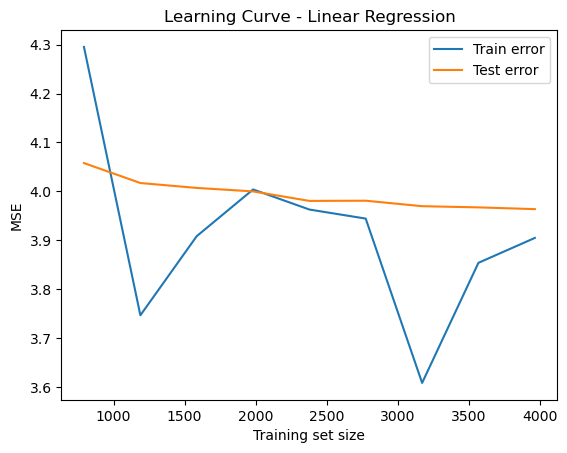

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(sklearn_LR_pipeline, X_train, Y_train,
                                                        scoring='neg_mean_squared_error',
                                                        train_sizes=np.linspace(0.2, 1.0, 9))

train_scores_mean_lr = -train_scores.mean(axis=1)
test_scores_mean_lr = -test_scores.mean(axis=1)

import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores_mean_lr, label="Train error")
plt.plot(train_sizes, test_scores_mean_lr, label="Test error")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve - Linear Regression")
plt.show()


### Polynomial Features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression())
])

poly_pipeline.fit(X_train, Y_train)

y_pred_poly = poly_pipeline.predict(X_test)


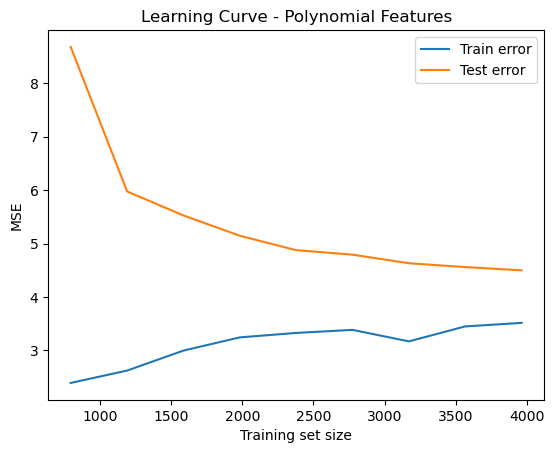

In [19]:
train_sizes, train_scores, test_scores = learning_curve(poly_pipeline, X_train, Y_train, cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        train_sizes=np.linspace(0.2, 1.0, 9))

train_scores_mean_poly = -train_scores.mean(axis=1)
test_scores_mean_poly = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean_poly, label="Train error")
plt.plot(train_sizes, test_scores_mean_poly, label="Test error")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve - Polynomial Features")
plt.show()

### Linear Regression with SelectKBest features

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

small_model = LinearRegression()

selector = SelectKBest(score_func=f_regression)

small_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('regressor', small_model)
])

k_grid = {
    'selector__k': np.linspace(2, 12, 11, dtype=int)
}

small_model = GridSearchCV(small_pipeline, k_grid, cv=5, scoring='r2', n_jobs=-1)

small_model.fit(X_train, Y_train)

y_pred_small = small_model.predict(X_test)
print(small_model.best_params_)

{'selector__k': np.int64(12)}


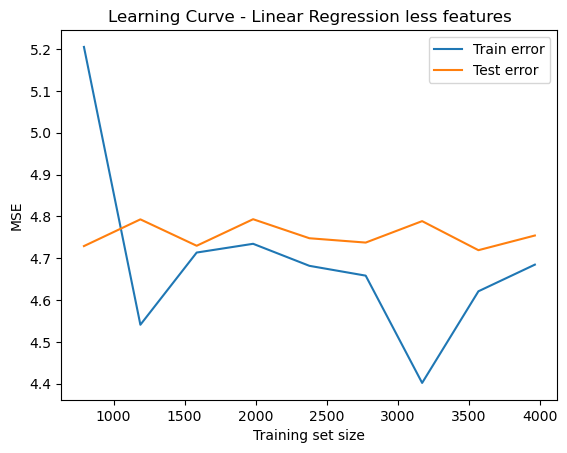

In [21]:
train_sizes, train_scores, test_scores = learning_curve(small_pipeline, X_train, Y_train, cv=5,
                                                        scoring='neg_mean_squared_error',
                                                        train_sizes=np.linspace(0.2, 1.0, 9))

train_scores_mean_small = -train_scores.mean(axis=1)
test_scores_mean_small = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean_small, label="Train error")
plt.plot(train_sizes, test_scores_mean_small, label="Test error")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve - Linear Regression less features")
plt.show()

#### All in one graph

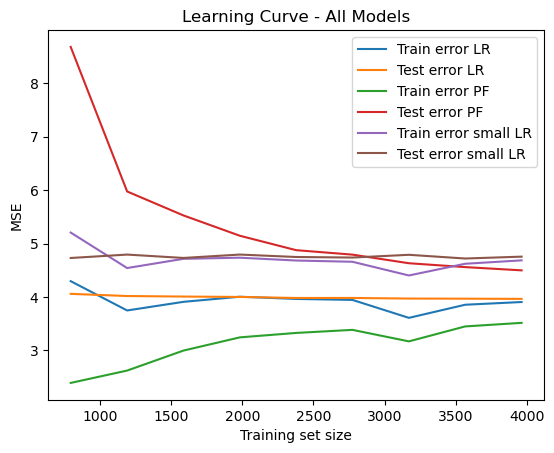

In [22]:
plt.plot(train_sizes, train_scores_mean_lr, label="Train error LR")
plt.plot(train_sizes, test_scores_mean_lr, label="Test error LR")
plt.plot(train_sizes, train_scores_mean_poly, label="Train error PF")
plt.plot(train_sizes, test_scores_mean_poly, label="Test error PF")
plt.plot(train_sizes, train_scores_mean_small, label="Train error small LR")
plt.plot(train_sizes, test_scores_mean_small, label="Test error small LR")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve - All Models")
plt.show()

#### Evaluation

In [23]:
from src.linear_regression.model_evaluation import metrics_table

df_metrics = metrics_table(Y_test, [y_pred_lr_skl, y_pred_poly, y_pred_small],
                           ['Linear Regression', 'Polynomial Features', 'Linear Regression less features'])

display(df_metrics)

,R²,MSE,RMSE,MAE
Linear Regression,0.691962,4.796682,2.190133,0.511425
Polynomial Features,0.666391,5.194873,2.279226,0.739651
Linear Regression less features,0.641655,5.580044,2.362212,0.927798


### Convergence graph for Gradient Descent

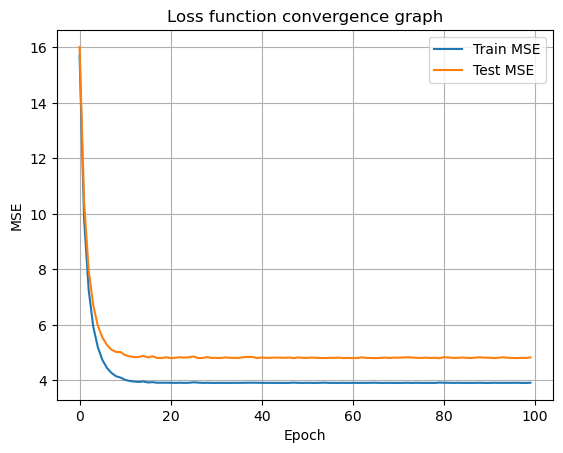

In [24]:
from src.linear_regression.models import LinearRegressionGradientDescent

LR_gd = LinearRegressionGradientDescent(learning_rate=0.01, n_epochs=100)
LR_gd.track_error(preprocessor.fit_transform(X_test), Y_test)

LR_gd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LR_gd)
])

LR_gd_pipeline.fit(X_train, Y_train)

import matplotlib.pyplot as plt

plt.plot(LR_gd.train_errors, label="Train MSE")
plt.plot(LR_gd.test_errors, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss function convergence graph")
plt.legend()
plt.grid(True)
plt.show()

#### And evaluation

In [25]:
y_pred_gd = LR_gd_pipeline.predict(X_test)

df_metrics_gd = metrics_table(Y_test, [y_pred_gd], ['Linear Regression Gradient Descent'])

display(df_metrics_gd)

,R²,MSE,RMSE,MAE
Linear Regression Gradient Descent,0.692154,4.793701,2.189452,0.538266
